# GAN for Sequential data

## Imports

In [1]:
import sys
sys.path.append("../../Scripts")

import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

from utils import onehot,num_parameters,sample_noise,true_target,fake_target
from layers import GumbelSoftmax
from generators import GumbelSARNNGenerator
from discriminators import GumbelSARNNDiscriminator

from Dataloaders.load_coco_captions_dataset import create_dataset
from visualize import plotSamples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_path = os.path.join("../Saved_models","SA-RNN-GAN")

print("Does model save path exist:",os.path.exists(model_save_path))

print(device)

Does model save path exist: True
cuda


## Dataset loading

In [2]:
batch_size = 128

data_dict = create_dataset("../../../Datasets/COCO2015Captions",batch_size,min_vocab_freq=100,max_vocab_size=None)
train_data,val_data,test_data = data_dict["data_iters"]
text_field = data_dict["fields"]
num_classes = data_dict["num_classes"]
SOS_TOKEN,EOS_TOKEN,UNK_TOKEN,PAD_TOKEN = data_dict["tokens"]
max_seq_len = data_dict["max_seq_len"]

train_iter = iter(train_data)
val_iter = iter(val_data)
test_iter = iter(train_data)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Dataset loaded
Train set size: 289879
Vocabuly build
Vocabuly statistics

Most common words in the vocabulary:
 [('a', 684546), ('on', 149490), ('of', 142745), ('the', 137947), ('in', 128745), ('with', 107681), ('and', 98721), ('is', 68632), ('man', 50780), ('to', 47713)]
Size of the vocabulary: 2284
Max sequence lenght 49


## Training setup

In [3]:
g_lr = 1e-4
d_lr = 3e-5

noise_size = 128

num_test_samples = 100
test_noise = sample_noise(num_test_samples,noise_size,device)

# intialize models
generator = GumbelSARNNGenerator(hidden_size=256,noise_size=noise_size,output_size=num_classes,
                               device=device,SOS_TOKEN=SOS_TOKEN).to(device)
discriminator = GumbelSARNNDiscriminator(input_size=num_classes,hidden_size=256,output_size=1).to(device)

# otpimizers
g_optimizer = optim.Adam(generator.parameters(),lr=g_lr)
d_optimizer = optim.Adam(discriminator.parameters(),lr=d_lr)
g_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_optimizer,mode="min",factor=0.5,patience=2,verbose=True)

# losses
loss_fun = nn.BCEWithLogitsLoss()
loss_weight = torch.ones(num_classes).to(device)
loss_weight[SOS_TOKEN] = 0.0
#loss_weight[EOS_TOKEN] = 0.0
#loss_weight[UNK_TOKEN] = 0.0
loss_weight[PAD_TOKEN] = 0.0
pretrain_loss_fun = nn.NLLLoss(weight=loss_weight)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error","beta"])
pretrain_dis = updatable_display2(['train'],["pretrain epoch","pretrain_g_error"])

np_g = num_parameters(generator)
np_d = num_parameters(discriminator)
print("Number of parameters for G: {}\nNumber of parameters for D: {}\nNumber of parameters in total: {}"
      .format(np_g,np_d,np_g+np_d))

Number of parameters for G: 1880877
Number of parameters for D: 669002
Number of parameters in total: 2549879


### Pretrain Generator

In [4]:
def pretrain_generator(real_data,fake_data,optimizer,model):
    '''
    Pretrain the generator to generate realistic samples for a good initialization
    '''
    num_classes = fake_data.size(2)
    # Reset gradients
    optimizer.zero_grad()
    
    loss = 0
    fake_data = torch.log(fake_data+1e-8)
    for i in range(fake_data.size(1)):
        loss += pretrain_loss_fun(fake_data[:,i,:],real_data[:,i])
    loss /= fake_data.size(1)
    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(),max_norm=1,norm_type="inf")
    optimizer.step()
    return loss

### Train Generator

In [5]:
def train_generator(real_data_onehot,fake_data,optimizer):
    '''
    Train the generator to generate realistic samples and thereby fool the discriminator
    '''
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data_onehot)

    # 1.2 Train on Fake Data
    fake_data_save = fake_data
    c_x_f = discriminator(fake_data)
        
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)
    
    loss_real = loss_fun(c_x_r-c_x_f_mean,fake_target(N,device))
    loss_fake = loss_fun(c_x_f-c_x_r_mean,true_target(N,device))
    
    loss = (loss_real + loss_fake)/2.0
    if torch.isnan(loss):
        print(fake_data_save)
        assert False
    loss.backward()
    
    optimizer.step()
    return loss

### Train Discriminator

In [6]:
def train_discriminator(real_data_onehot,fake_data,optimizer):
    '''
    Train the discriminator to distinguish between real and fake data
    '''
    N = real_data_onehot.size(0)
    
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    c_x_r = discriminator(real_data_onehot)

    # 1.2 Train on Fake Data
    fake_data_save = fake_data
    c_x_f = discriminator(fake_data)
        
    # compute the average of c_x_*
    c_x_r_mean = torch.mean(c_x_r,dim=0)
    c_x_f_mean = torch.mean(c_x_f,dim=0)
        
    loss_real = loss_fun(c_x_r-c_x_f_mean,true_target(N,device))
    loss_fake = loss_fun(c_x_f-c_x_r_mean,fake_target(N,device))
    
    loss = (loss_real + loss_fake)/2.0
    if torch.isnan(loss):
        print(fake_data_save)
        assert False
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    return loss

## Train the model

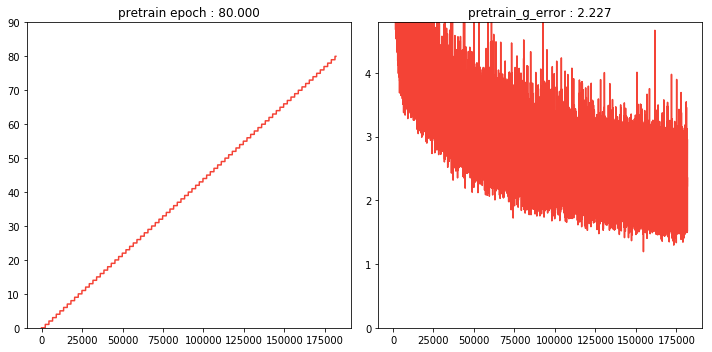

In [ ]:
gen_steps = 1
gen_train_freq = 1
max_temperature = torch.FloatTensor([2]).to(device)
pretrain_temperature = torch.FloatTensor([1]).to(device)

epochs_pretrain = 100
pretrain_step = 0

num_epochs = 200
global_step = 0
epoch = 0
d_error = 0
g_error = 0

# pretrain generator
for ep in range(epochs_pretrain):
    train_iter = iter(train_data)
    batch_error = []
    for n_batch,batch in enumerate(train_iter):
        real_data = batch.text.to(device)
        N = real_data.size(0)
        num_steps = real_data.size(1)
        real_data_onehot = onehot(real_data,num_classes)

        # Generate fake data
        generator.train()
        noise = sample_noise(N,noise_size,device)
        fake_data = generator(z=noise,num_steps=num_steps,temperature=pretrain_temperature,
                              x=real_data.long())
        if torch.isnan(fake_data).any():
            noise = sample_noise(N,noise_size,device)
            fake_data = generator(z=noise,num_steps=num_steps,temperature=pretrain_temperature,
                                  x=real_data.long())
        # Train G
        pretrain_g_error = pretrain_generator(real_data,fake_data,g_optimizer,generator)
        batch_error.append(pretrain_g_error)
        
        # Log batch error and delete tensors
        pretrain_dis.update(pretrain_step,'train',{"pretrain epoch":ep,"pretrain_g_error":pretrain_g_error.item()})
        pretrain_step += 1
        if pretrain_step % 200 == 0:
            pretrain_dis.display(scale=True)
        torch.cuda.empty_cache()
    g_lr_scheduler.step(torch.stack(batch_error).mean())
    """
    if ep % 10 == 0:
        generator.eval()
        test_samples = generator(z=test_noise,num_steps=num_steps,temperature=pretrain_temperature)
        test_samples_vals = torch.argmax(test_samples,dim=2)
        plotSamples(test_samples_vals,xu=num_steps,yu=vocab_size,title="Fake data")
        plt.show()
    """
        
# train adverserially
try:
    while epoch < num_epochs:
        train_iter = iter(train_data)
        temperature = max_temperature**((epoch+1)/num_epochs)
        for n_batch,batch in enumerate(train_iter):
            real_data = batch.text.to(device)
            N = real_data.size(0)
            num_steps = real_data.size(1)
            # 1. Train Discriminator
            real_data_onehot = onehot(real_data,num_classes)
            real_data_onehot[real_data_onehot==1] = 0.9
            real_data_onehot[real_data_onehot==0] = (1.0-0.9)/(vocab_size-1.0)

            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = sample_noise(N,noise_size,device)
            with torch.no_grad():
                fake_data = generator(z=noise_tensor,num_steps=num_steps,temperature=temperature).detach()
            if torch.isnan(fake_data).any():
                print(noise_tensor)
                assert False
            # Train D
            d_error = train_discriminator(real_data_onehot,fake_data,d_optimizer)

            # 2. Train Generator every 'gen_train_freq' steps
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # Generate fake data
                    noise_tensor = sample_noise(N,noise_size,device)
                    fake_data = generator(z=noise_tensor,num_steps=num_steps,temperature=temperature)
                    if torch.isnan(fake_data).any():
                        print(noise_tensor)
                        assert False
                    # Train G
                    g_error = train_generator(real_data_onehot,fake_data,g_optimizer)
                    g_error = g_error.item()

            # Log batch error and delete tensors
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error,
                                            "beta":temperature.item()})
            global_step += 1

            # Display Progress every few batches
            if global_step % 50 == 0:
                #test_samples = generator(z=test_noise,num_steps=num_steps,temperature=temperature)
                #test_samples_vals = torch.argmax(test_samples,dim=2)
                dis.display(scale=True)
                #plotSamples(real_data,xu=num_steps,yu=num_classes,title="Real data")
                #plotSamples(test_samples_vals,xu=num_steps,yu=num_classes,title="Fake data")
                #if epoch % 50 == 0:
                #    plt.savefig("Figures/RaSGAN-SA-ToyData-Epoch="+str(epoch)+".png")
                #plt.show()
        epoch += 1
except:
    #test_samples = generator(z=test_noise,num_steps=num_steps,temperature=temperature)
    #test_samples_vals = torch.argmax(test_samples,dim=2)
    dis.display(scale=True)
    #plotSamples(real_data,xu=num_steps,yu=num_classes,title="Real data")
    #plotSamples(test_samples_vals,xu=num_steps,yu=num_classes,title="Fake data")
    #plt.savefig("Figures/RaSGAN-SA-ToyData.png")
    #plt.show()

## Save model

In [ ]:
save_model(generator,model_save_path)
save_model(discriminator,model_save_path)

# to load model run
#load_model(model,model_load_path)

### Eval generator function

In [ ]:
def nll_gen(real_data,fake_data):
    '''
    Evaluate the generators ability to generate diverse samples
    '''    
    loss = 0
    fake_data = torch.log(fake_data)
    for i in range(fake_data.size(1)):
        loss += pretrain_loss_fun(fake_data[:,i,:],real_data[:,i])
    loss /= fake_data.size(1)
    return loss

## Evaluate generator

In [ ]:
#torch.cuda.empty_cache()

# evaluate generator
nll_gen_error = []
for n_batch,real_batch in enumerate(val_iter):
    real_batch = batch.text
    N = real_batch.size(0)
    num_steps = real_batch.size(1)
    real_batch = real_batch.squeeze(2)
    real_data = real_batch.to(device)

    # Generate fake data
    generator.eval()
    noise = sample_noise(N,noise_size,device)
    fake_data = generator(z=noise,num_steps=num_steps,temperature=max_temperature,
                          x=real_data.long())
    # Train G
    nll_g_error = nll_gen(real_data,fake_data)
    nll_gen_error.append(nll_g_error)

nll_gen_error = torch.stack(nll_gen_error)
print(nll_gen_error.mean())